In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostRegressor
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

seed = 2025 - 10 - 3
np.random.seed(seed=seed)

In [ ]:
train_candles = pd.read_csv(
    "/Users/ivan/Desktop/универ/прочее/finam_hack/finam-x-hse-trade-ai-hack-forecast-main/data/raw/participants/train_candles.csv"
)
public_test_candels = pd.read_csv(
    "/Users/ivan/Desktop/универ/прочее/finam_hack/finam-x-hse-trade-ai-hack-forecast-main/data/raw/participants/public_test_candles.csv"
)
train_candles["begin"] = pd.to_datetime(train_candles["begin"], format="%Y-%m-%d")

In [ ]:
# Отрежем данные до марта 2022 включительно из-за нарушения временной составляющей
train_candles = train_candles[train_candles["begin"] >= pd.to_datetime("2022-04-01")]

In [31]:
n_tickers = train_candles["ticker"].nunique()
n_tickers

19

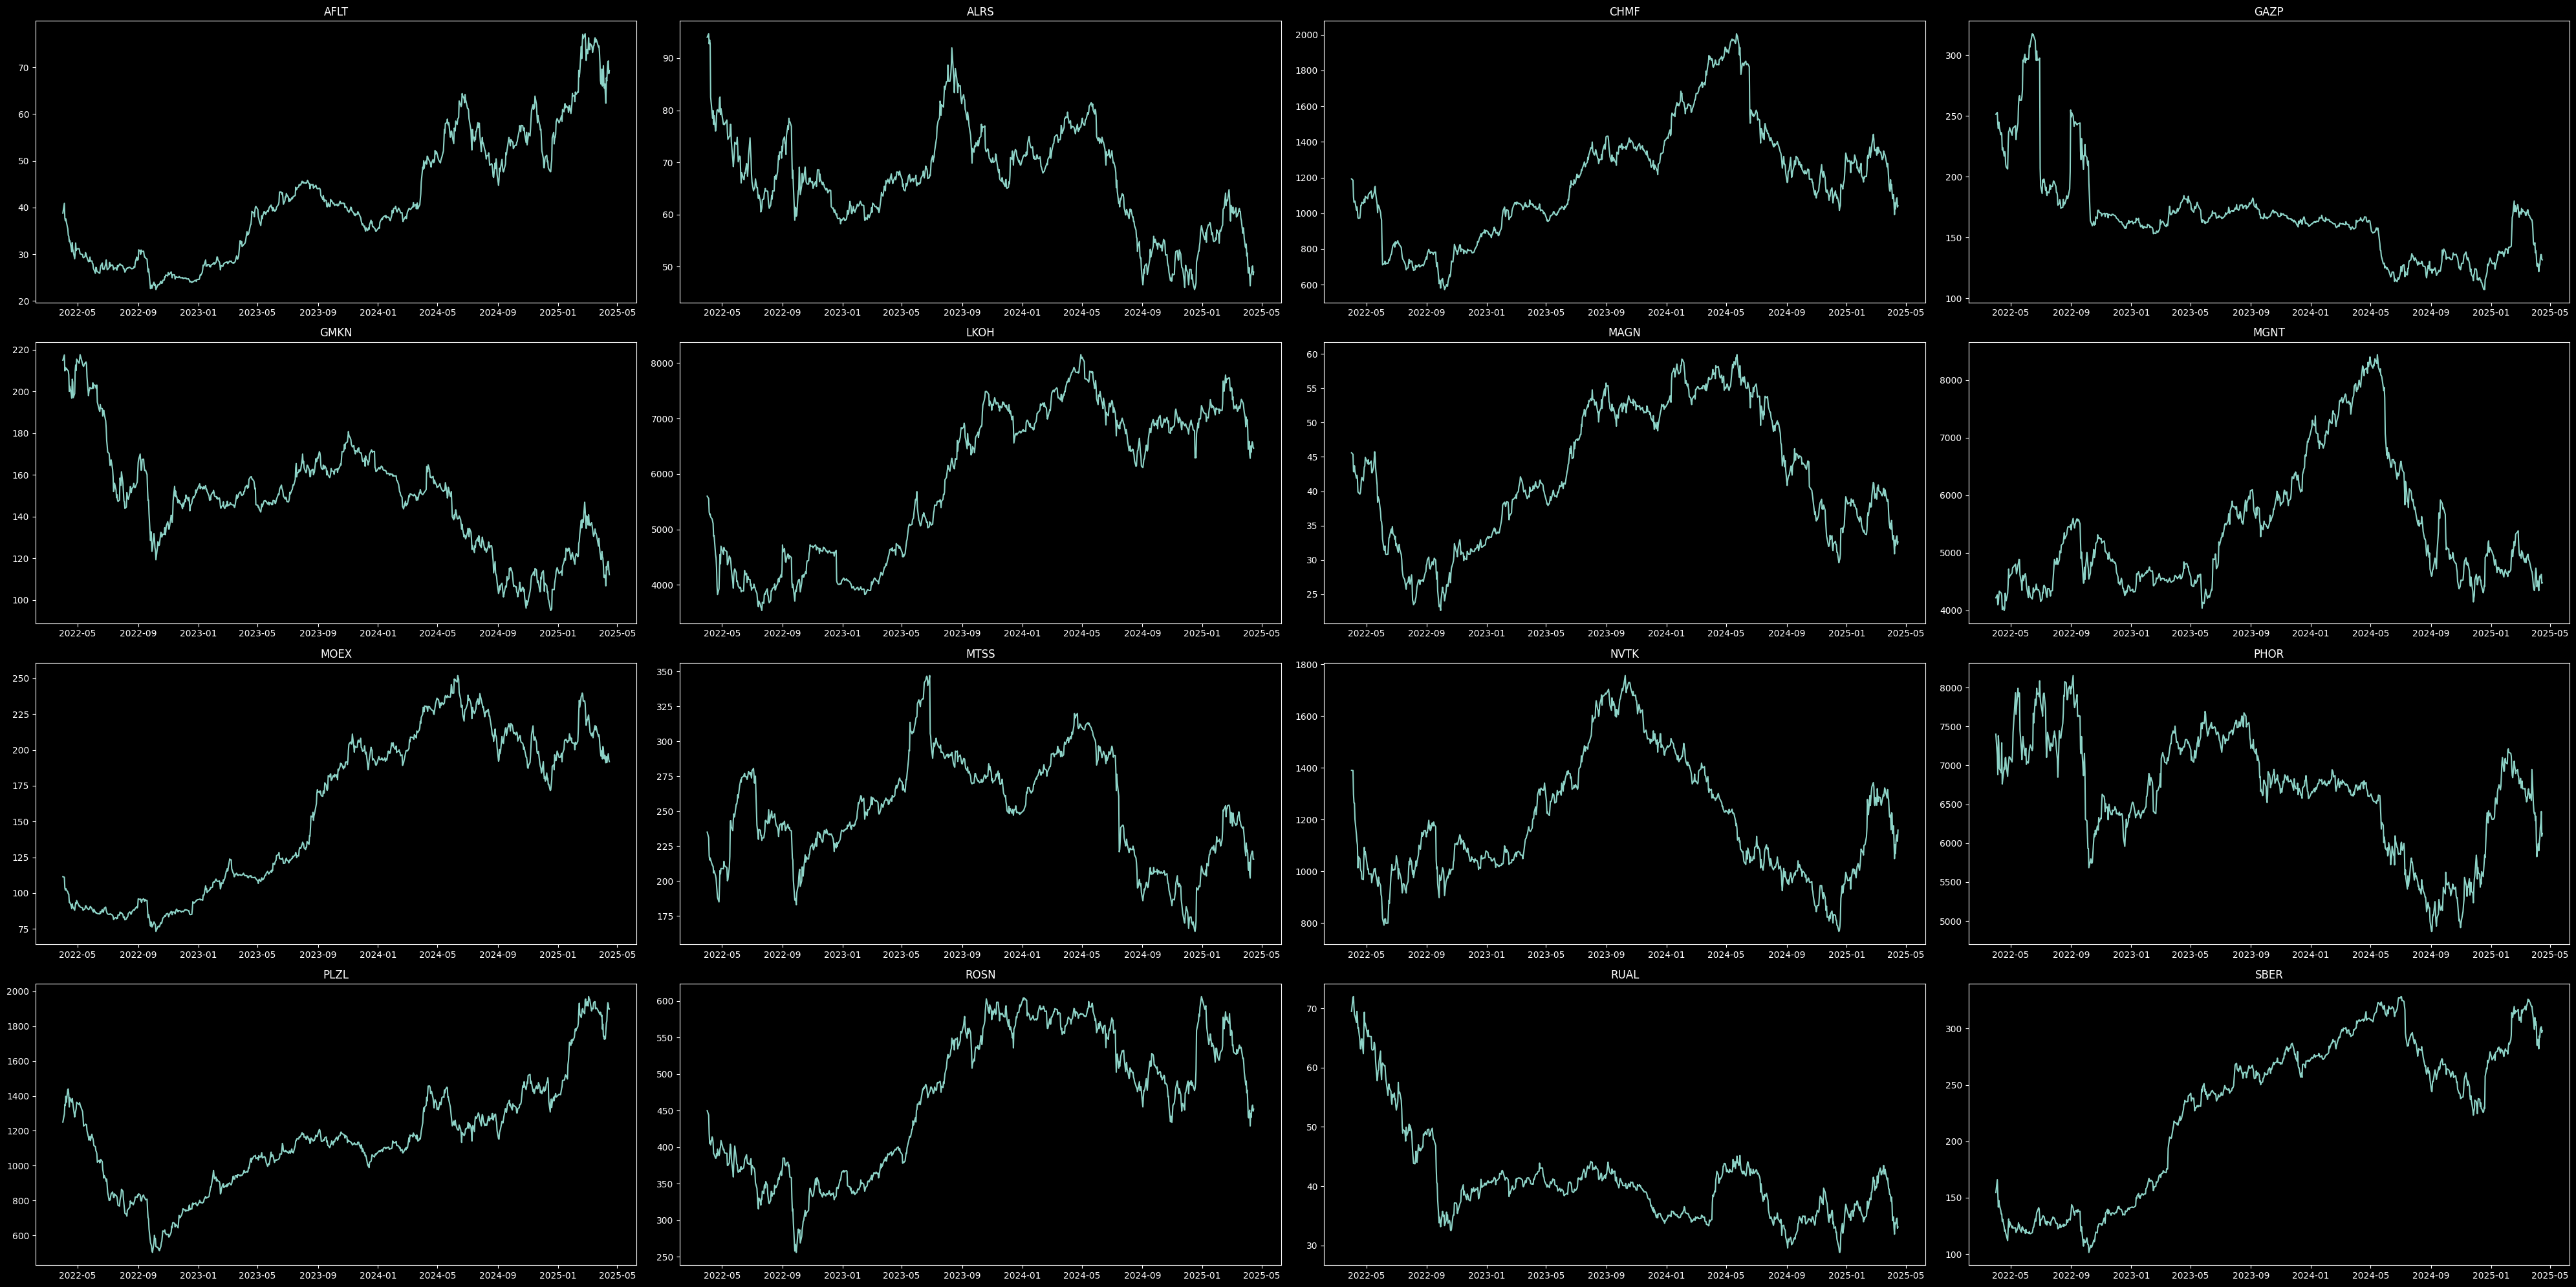

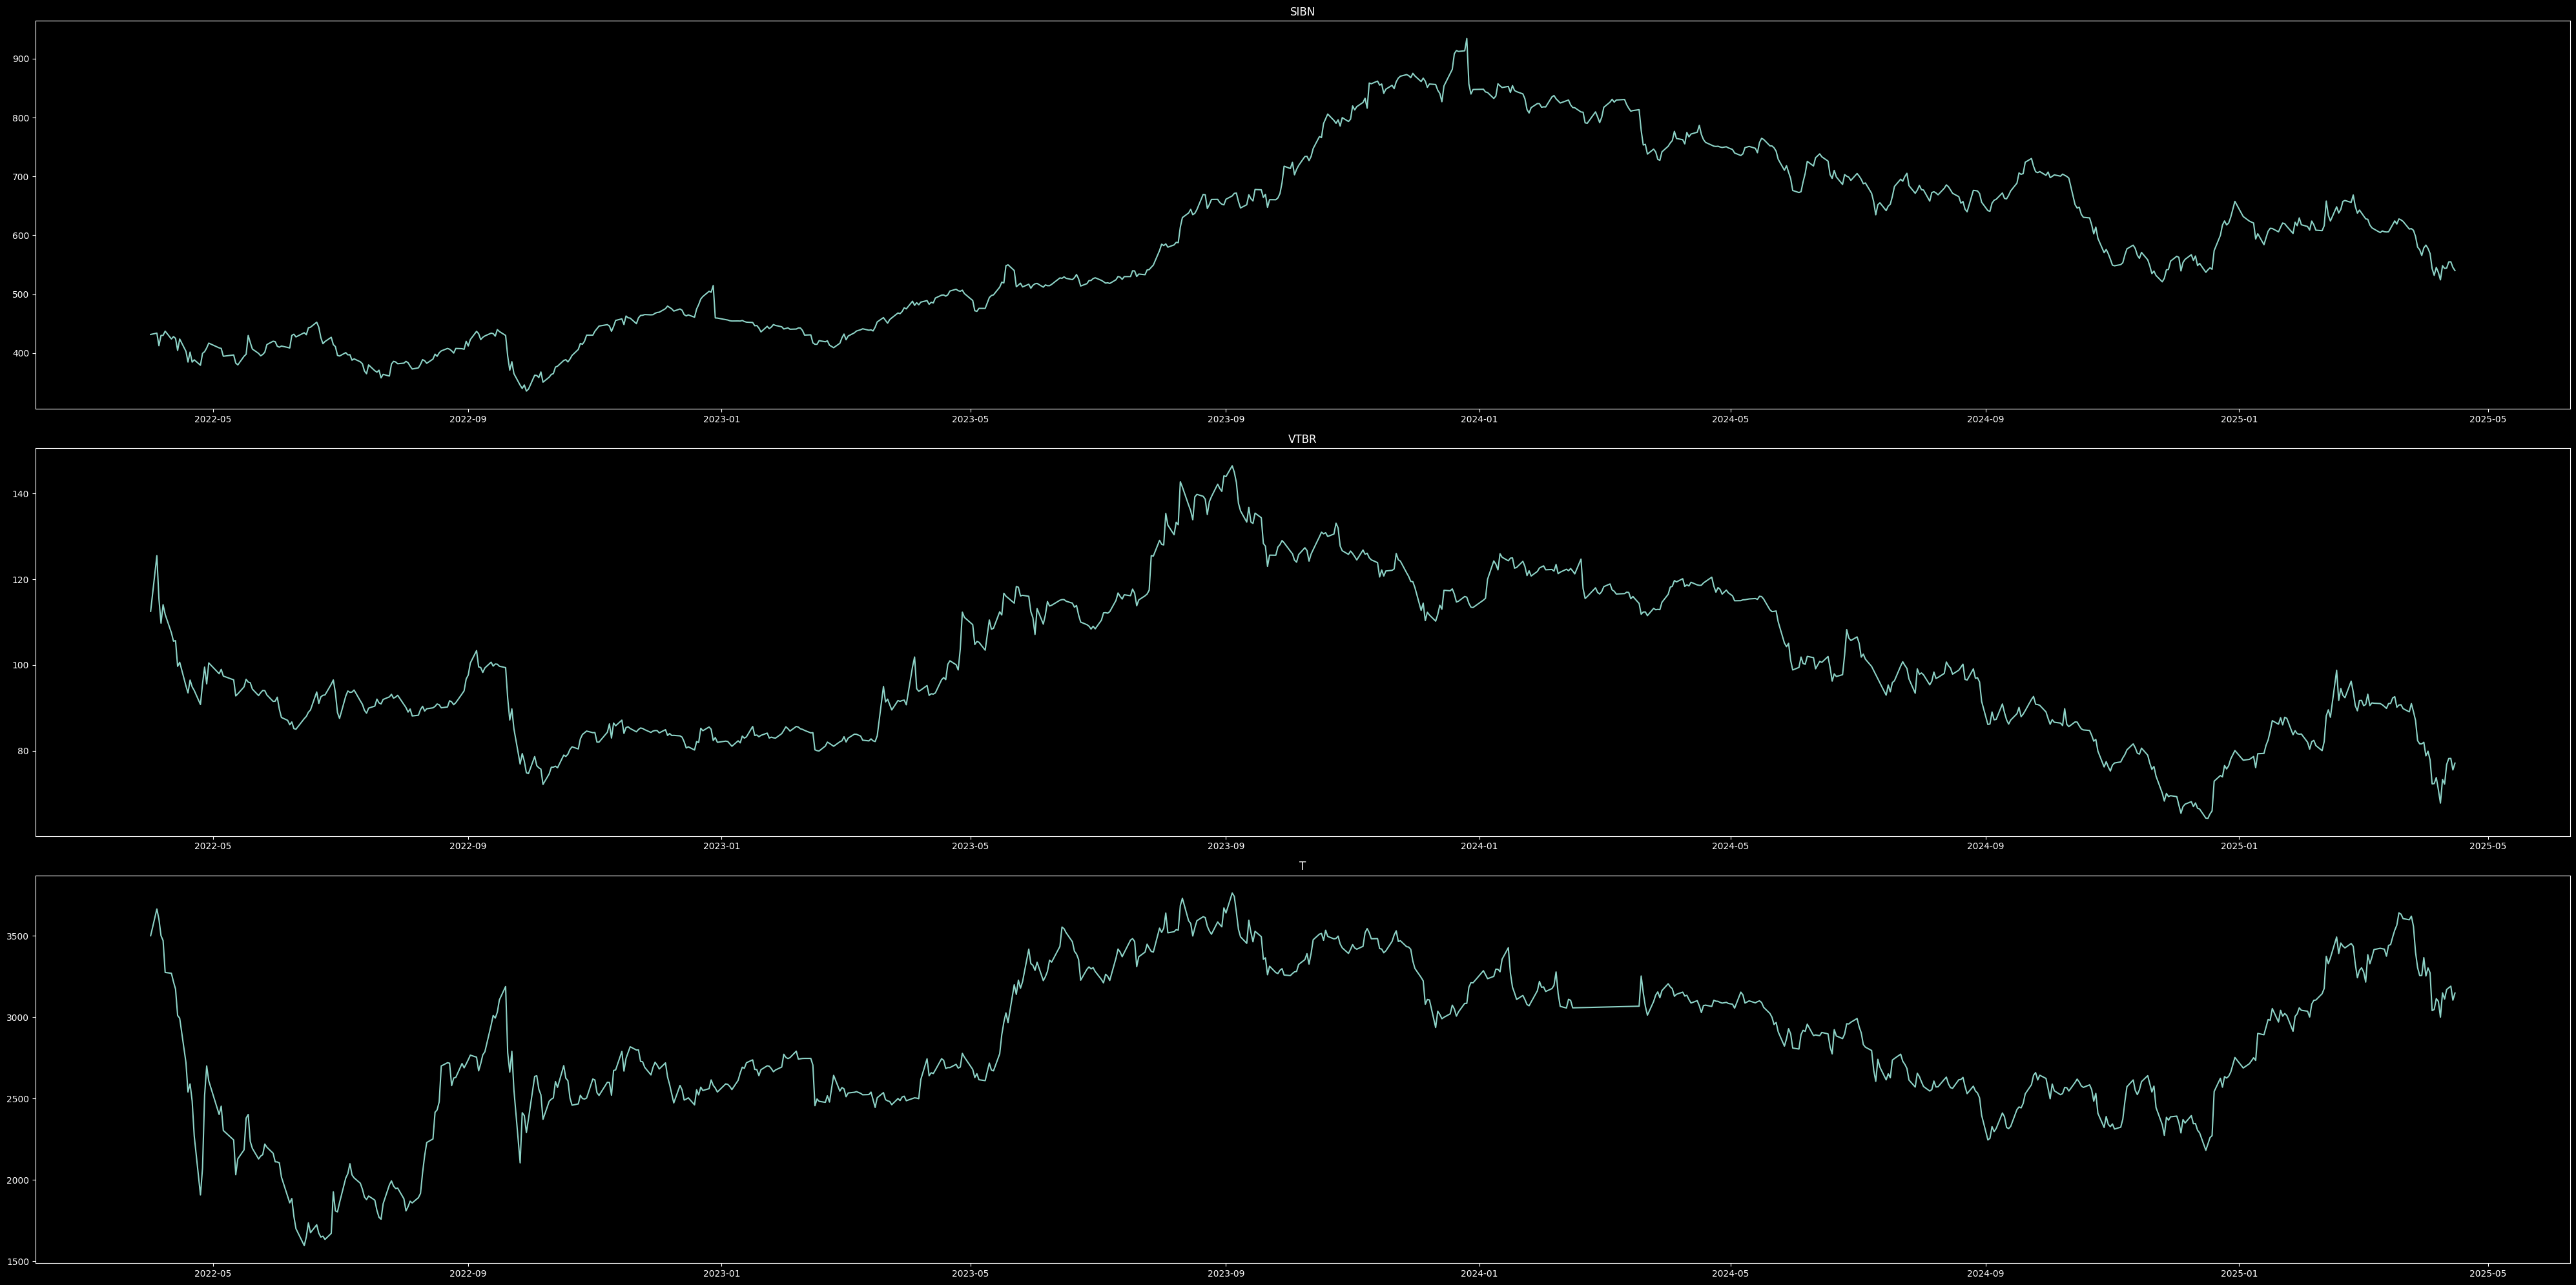

In [ ]:
fig, axs = plt.subplots(4, 4, figsize=(40, 20))
for i in range(n_tickers - 3):
    mask = train_candles["ticker"] == train_candles["ticker"].unique()[i]
    axs[i // 4][i % 4].plot(
        train_candles.loc[mask, "begin"], train_candles.loc[mask, "close"]
    )
    axs[i // 4, i % 4].set_title(train_candles["ticker"].unique()[i])
plt.tight_layout()
plt.show()

fig, axs = plt.subplots(3, 1, figsize=(40, 20))
for i in range(n_tickers - 3, n_tickers):
    mask = train_candles["ticker"] == train_candles["ticker"].unique()[i]
    axs[n_tickers - i - 3].plot(
        train_candles.loc[mask, "begin"], train_candles.loc[mask, "close"]
    )
    axs[n_tickers - i - 3].set_title(train_candles["ticker"].unique()[i])
plt.tight_layout()
plt.show()

In [26]:
to_check_columns = train_candles.copy()

In [ ]:
# гипотеза, что разности величин могут давать корреляцию с потенциальными таргетами
to_check_columns["close_minus_open"] = (
    to_check_columns["close"] - to_check_columns["open"]
)
to_check_columns["high_minus_open"] = to_check_columns["high"] - to_check_columns["low"]
to_check_columns["low_minus_open"] = to_check_columns["low"] - to_check_columns["open"]
to_check_columns["high_minus_low"] = to_check_columns["high"] - to_check_columns["low"]

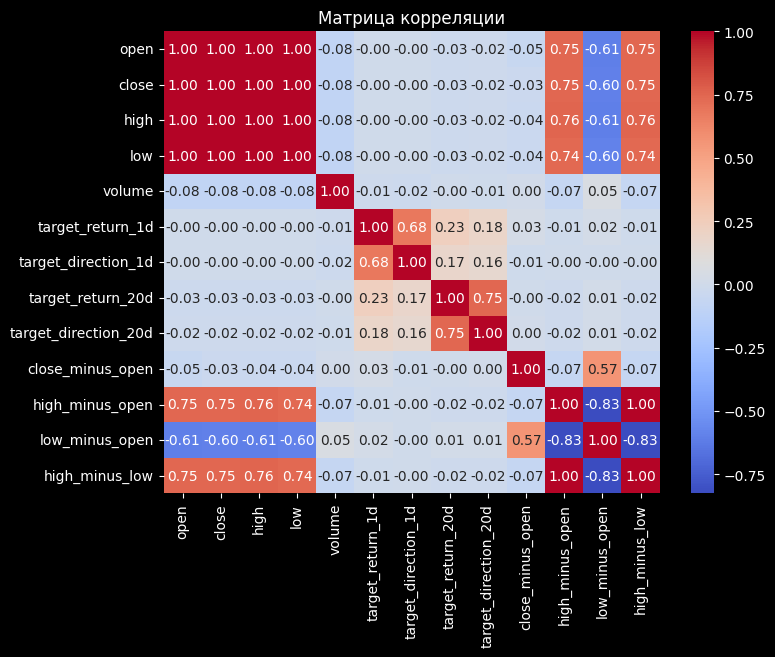

In [ ]:
# гипотеза опровергнута для линейных взаимодействий
correlation_matrix = to_check_columns.select_dtypes(include=[np.number]).corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Матрица корреляции")
plt.show()

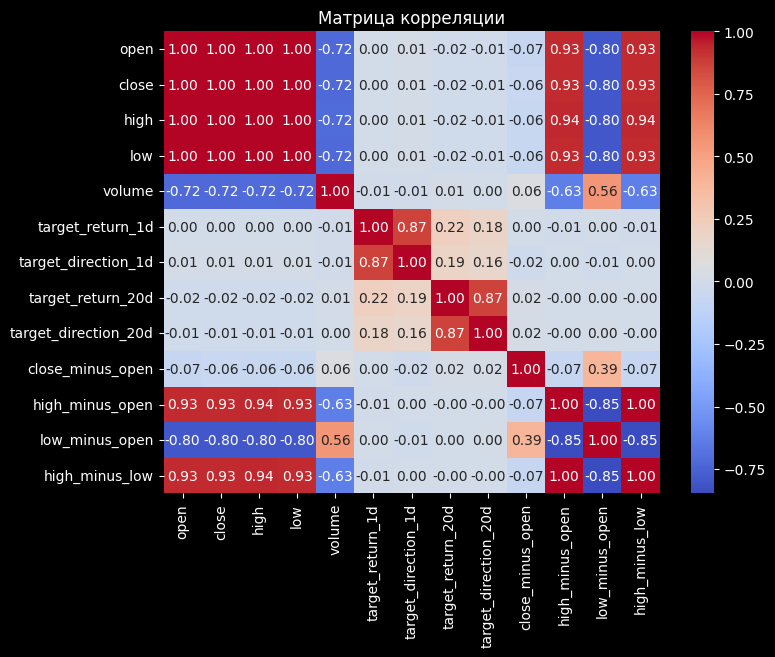

In [ ]:
# гипотеза для нелинейных монотонных взаимодействий также отвергнута
correlation_matrix_spearman = to_check_columns.select_dtypes(include=[np.number]).corr(
    method="spearman"
)
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix_spearman, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Матрица корреляции")
plt.show()

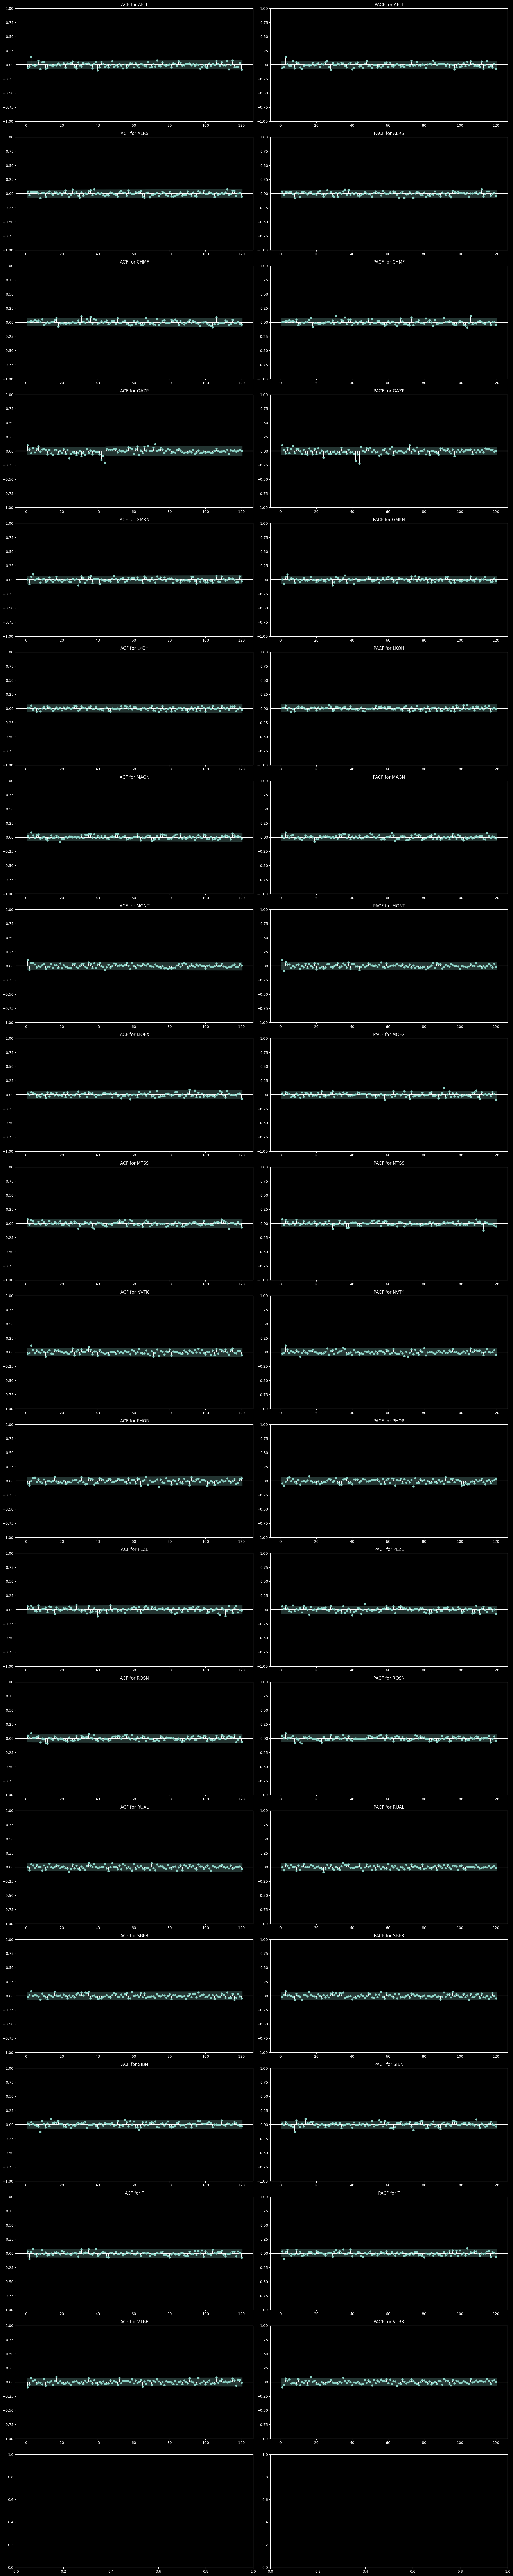

In [ ]:
n_rows = n_tickers + 1
fig, axs = plt.subplots(n_rows, 2, figsize=(20, 100))
for i in range(n_tickers):
    mask = train_candles["ticker"] == train_candles["ticker"].unique()[i]
    series = train_candles.loc[mask, "close"].diff().dropna()
    plot_acf(
        series,
        ax=axs[i][0],
        title=f"ACF for {train_candles['ticker'].unique()[i]}",
        lags=120,
        zero=False,
    )
    plot_pacf(
        series,
        ax=axs[i][1],
        title=f"PACF for {train_candles['ticker'].unique()[i]}",
        lags=120,
        zero=False,
    )

plt.tight_layout()
plt.show()